In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [2]:
# Load the CSV file
dataframe = pd.read_csv('file_mapping.csv')

# Shuffle the DataFrame
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# Define base path
base_path = 'input'

# Adjust the file paths
def adjust_path(path, base_path):
    normalize = path.replace('\\', '/')
    return os.path.join(base_path, normalize.lstrip('/'))

# Apply the path adjustment function to create full paths for the images
dataframe['adjusted_path'] = dataframe['Filename'].apply(lambda x: adjust_path(x, base_path))

# Map labels to binary values (assuming labels are 'Genuine' or 'Fake')
dataframe['Label'] = dataframe['Label'].map({'Genuine': 1, 'Fake': 0})

# Extract image paths and labels
image_paths = dataframe['adjusted_path'].values
labels = dataframe['Label'].values

# Function to load images and labels
def load_images_and_labels(image_paths, labels):
    images = []
    valid_labels = []

    for img_path, label in zip(image_paths, labels):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
            valid_labels.append(label)
    
    return images, valid_labels

# Load the images and corresponding labels
images, labels = load_images_and_labels(image_paths, labels)

In [3]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [4]:
sift = cv2.SIFT_create()

def extract_sift_features(images):
    features = []
    for img in images:
        keypoints, descriptors = sift.detectAndCompute(img, None)
        if descriptors is not None:
            features.append(descriptors)
        else:
            features.append(np.zeros((1, 128)))  # Placeholder for images with no keypoints
    return features

# Extract SIFT features from the images
features = extract_sift_features(images)

# Check if features list is empty or contains valid descriptors
if len(features) == 0 or all(len(f) == 0 for f in features):
    raise ValueError("No valid SIFT descriptors found in the images. Please check your data.")

# Flatten and stack all descriptors
all_descriptors = np.vstack(features)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=50)
pca.fit(all_descriptors)

# Transform and flatten the features after PCA
pca_features = []
for desc in features:
    pca_transformed = pca.transform(desc)
    pca_transformed_flat = pca_transformed.flatten()

    # Ensure all vectors are of the same length
    # Pad with zeros if necessary
    target_length = 50 * len(desc)  # 50 components per keypoint
    if len(pca_transformed_flat) < target_length:
        pca_transformed_flat = np.pad(pca_transformed_flat, (0, target_length - len(pca_transformed_flat)), 'constant')

    pca_features.append(pca_transformed_flat)

# Determine the maximum length to pad all features to the same size
max_length = max([len(x) for x in pca_features])

# Pad each feature vector to the same length
X = np.array([np.pad(x, (0, max_length - len(x)), 'constant') for x in pca_features])
y = np.array(labels)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a Support Vector Machine (SVM) classifier
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict on the test set
y_pred = svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 57.26%


In [5]:
def manual_test_image(image, sift, pca, svm, max_length):
    # Extract SIFT features
    keypoints, descriptors = sift.detectAndCompute(image, None)
    
    if descriptors is None:
        descriptors = np.zeros((1, 128))  # Placeholder if no keypoints are found

    # Transform with PCA
    pca_transformed = pca.transform(descriptors)
    pca_transformed_flat = pca_transformed.flatten()

    # Pad the transformed features to match the expected input size
    target_length = max_length
    if len(pca_transformed_flat) < target_length:
        pca_transformed_flat = np.pad(pca_transformed_flat, (0, target_length - len(pca_transformed_flat)), 'constant')

    # Convert to numpy array and reshape to match the input shape for the model
    test_feature = np.array([pca_transformed_flat])
    
    # Predict using the trained SVM model
    prediction = svm.predict(test_feature)

    return prediction[0]

# Load the image you want to test
test_image_path = 'samp2.jpeg'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

# Ensure the image is loaded correctly
if test_image is None:
    raise ValueError(f"Image not found or failed to load: {test_image_path}")

# Test the model with the image
predicted_label = manual_test_image(test_image, sift, pca, svm, max_length)

print(f"Predicted label: {predicted_label}")


Predicted label: 1


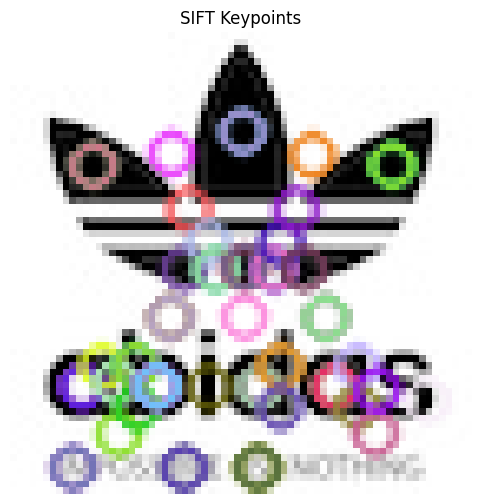

In [6]:
import matplotlib.pyplot as plt
import cv2

def show_sift_keypoints(image):
    keypoints, _ = sift.detectAndCompute(image, None)
    img_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_with_keypoints, cmap='gray')
    plt.title('SIFT Keypoints')
    plt.axis('off')
    plt.show()

# Load the image
test_image_path = 'samp2.jpeg'
test_image = cv2.imread(test_image_path, cv2.IMREAD_GRAYSCALE)

if test_image is None:
    raise ValueError(f"Image not found or failed to load: {test_image_path}")

# Show SIFT keypoints for the loaded image
show_sift_keypoints(test_image)
